### STEP 1: SETUP AND IMPORTS

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
import optuna
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

In [4]:
data = train_data.copy()
data1 = test_data.copy()

### Dataset loading part

In [5]:
# Create working copies
datasets = {'train': data, 'test': data1}

In [6]:
data.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [7]:
data.shape

(750000, 18)

In [8]:
data.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

## Feature Engineering

#### 1. DURATION-BASED FEATURES (Most important for bank marketing datasets)

In [9]:
for name, data in datasets.items():
    print(f"Processing {name} - Duration features...")
    
    if 'duration' in data.columns:
        # Mathematical transformations
        data['duration_log'] = np.log1p(data['duration'])
        data['duration_sqrt'] = np.sqrt(data['duration'])
        data['duration_squared'] = data['duration'] ** 2
        data['duration_zscore'] = stats.zscore(data['duration'])
        
        # Granular thresholds
        data['micro_call'] = (data['duration'] <= 30).astype(int)
        data['short_call'] = (data['duration'].between(31, 120)).astype(int)
        data['medium_call'] = (data['duration'].between(121, 300)).astype(int)
        data['long_call'] = (data['duration'].between(301, 600)).astype(int)
        data['ultra_long_call'] = (data['duration'] > 600).astype(int)
        
        # Campaign interactions
        if 'campaign' in data.columns:
            data['duration_per_campaign'] = data['duration'] / (data['campaign'] + 1)
            data['duration_campaign_ratio'] = data['duration'] / np.log1p(data['campaign'])
            data['efficiency_score'] = data['duration'] * np.log1p(data['campaign'])
        
        print(f" {name} duration features : {data.shape}")

# Update datasets
train, test = datasets['train'], datasets['test']

Processing train - Duration features...
 train duration features : (750000, 30)
Processing test - Duration features...
 test duration features : (250000, 29)


In [10]:
data.shape

(250000, 29)

#### 2. CUSTOMER FINANCIAL PROFILE

In [11]:
for name, data in datasets.items():
    print(f"Processing {name} - Balance features...")
    
    if 'balance' in data.columns:
        # Advanced transformations
        data['balance_log'] = np.sign(data['balance']) * np.log1p(np.abs(data['balance']))
        data['balance_sqrt'] = np.sign(data['balance']) * np.sqrt(np.abs(data['balance']))
        
        # Extreme value indicators
        data['balance_extreme_high'] = (data['balance'] > data['balance'].quantile(0.95)).astype(int)
        data['balance_extreme_low'] = (data['balance'] < data['balance'].quantile(0.05)).astype(int)
        data['negative_balance'] = (data['balance'] < 0).astype(int)
        data['zero_balance'] = (data['balance'] == 0).astype(int)
        data['positive_balance'] = (data['balance'] > 0).astype(int)
        
        # Age interactions
        if 'age' in data.columns:
            data['balance_per_age'] = data['balance'] / (data['age'] + 1)
            data['wealth_maturity'] = data['balance'] * data['age'] / 10000
            data['age_wealth_interaction'] = data['age'] * np.log1p(np.abs(data['balance']) + 1)
        
        print(f"  {name} Customer Financial Profile features: {data.shape}")

# Update datasets
train, test = datasets['train'], datasets['test']

Processing train - Balance features...
  train Customer Financial Profile features: (750000, 40)
Processing test - Balance features...
  test Customer Financial Profile features: (250000, 39)


In [12]:
data.shape

(250000, 39)

### 3. CAMPAIGN SOPHISTICATION

In [13]:
for name, data in datasets.items():
    print(f"Processing {name} - Campaign features...")
    
    if 'campaign' in data.columns:
        # Mathematical transformations
        data['campaign_log'] = np.log1p(data['campaign'])
        data['campaign_sqrt'] = np.sqrt(data['campaign'])
        
        # Granular campaign categorization
        data['single_campaign'] = (data['campaign'] == 1).astype(int)
        data['optimal_campaigns'] = (data['campaign'].between(2, 3)).astype(int)
        data['moderate_campaigns'] = (data['campaign'].between(4, 6)).astype(int)
        data['excessive_campaigns'] = (data['campaign'] > 6).astype(int)
        
        # If you have duration data, add these critical interactions:
        if 'duration' in data.columns:
            data['duration_per_campaign'] = data['duration'] / (data['campaign'] + 1)
            data['efficiency_score'] = data['duration'] * np.log1p(data['campaign'])
        
        print(f"  {name} Campaign features: {data.shape}")

# Update datasets
train, test = datasets['train'], datasets['test']

Processing train - Campaign features...
  train Campaign features: (750000, 46)
Processing test - Campaign features...
  test Campaign features: (250000, 45)


In [14]:
data.shape

(250000, 45)

### 4. AGE INTELLIGENCE

In [15]:
for name, data in datasets.items():
    print(f"Processing {name} - Age features...")
    
    if 'age' in data.columns:
        # Non-linear transformations
        data['age_log'] = np.log1p(data['age'])
        data['age_sqrt'] = np.sqrt(data['age'])
        data['age_squared'] = data['age'] ** 2
        
        # Life stage precision
        data['teenager'] = (data['age'] < 20).astype(int)
        data['young_adult'] = (data['age'].between(20, 25)).astype(int)
        data['young_professional'] = (data['age'].between(26, 35)).astype(int)
        data['established_career'] = (data['age'].between(36, 45)).astype(int)
        data['senior_career'] = (data['age'].between(46, 55)).astype(int)
        data['pre_retirement'] = (data['age'].between(56, 65)).astype(int)
        data['retirement_age'] = (data['age'] > 65).astype(int)
        
        print(f"  {name} Age Intelligence features: {data.shape}")

# Update datasets
train, test = datasets['train'], datasets['test']

Processing train - Age features...
  train Age Intelligence features: (750000, 56)
Processing test - Age features...
  test Age Intelligence features: (250000, 55)


In [16]:
data.shape

(250000, 55)

### 5. Monthly Time period Intelligence

In [17]:
for name, data in datasets.items():
    print(f"Processing {name} - Mothly Time Period features...")

    if 'day' in data.columns:
        # Mathematical transformation
        data['day_log'] = np.log1p(data['day'])
        
        # Temporal segmentation
        data['early_month'] = (data['day'] <= 7).astype(int)
        data['mid_month'] = (data['day'].between(8, 23)).astype(int)
        data['late_month'] = (data['day'] >= 24).astype(int)
        
        print("Temporal intelligence features created")
        
    # If you have 'month' data, add seasonal features:
    if 'month' in data.columns:
        data['q1_month'] = (data['month'].isin([1, 2, 3])).astype(int)  # New year
        data['q2_month'] = (data['month'].isin([4, 5, 6])).astype(int)  # Spring
        data['q3_month'] = (data['month'].isin([7, 8, 9])).astype(int)  # Summer
        data['q4_month'] = (data['month'].isin([10, 11, 12])).astype(int) # Holiday season
        
        print(f"  {name} Monthly time period features: {data.shape}")
        
# Update datasets
train, test = datasets['train'], datasets['test']        

Processing train - Mothly Time Period features...
Temporal intelligence features created
  train Monthly time period features: (750000, 64)
Processing test - Mothly Time Period features...
Temporal intelligence features created
  test Monthly time period features: (250000, 63)


In [18]:
data.shape

(250000, 63)

### 6. SEASONAL & MONTHLY SOPHISTICATION

In [19]:
for name, data in datasets.items():
    print(f"Processing {name} - Season & Mothly features...")

    month_cols = [col for col in data.columns if col.startswith('month')]
    if month_cols:
        # Complete meteorological seasons
        seasons = {
            'winter': ['month_dec', 'month_jan', 'month_feb'],
            'spring': ['month_mar', 'month_apr', 'month_may'], 
            'summer': ['month_jun', 'month_jul', 'month_aug'],  # Include August
            'fall': ['month_sep', 'month_oct', 'month_nov']
        }
        
        for season, months in seasons.items():
            available = [m for m in months if m in data.columns]
            if available:
                data[f'season_{season}'] = data[available].sum(axis=1)
        
        # Data-driven high-performance months (use the original insight)
        high_perf_months = ['month_may', 'month_jun', 'month_nov', 'month_dec']
        available_high_perf = [m for m in high_perf_months if m in data.columns]
        if available_high_perf:
            data['high_performance_month'] = data[available_high_perf].sum(axis=1)
            
        print(f"  {name} Seasonal & Monthly features: {data.shape}")
        
        print("Enhanced seasonal features created")
        
# Update datasets
train, test = datasets['train'], datasets['test']         

Processing train - Season & Mothly features...
  train Seasonal & Monthly features: (750000, 64)
Enhanced seasonal features created
Processing test - Season & Mothly features...
  test Seasonal & Monthly features: (250000, 63)
Enhanced seasonal features created


In [20]:
data.shape

(250000, 63)

### 7. LOAN RISK COMBINATIONS

In [21]:
for name, data in datasets.items():
    print(f"Processing {name} - Loan Risk features...")
    
    # Binary yes/no → 0/1
    binary_cols = ['loan', 'housing', 'default']
    for col in binary_cols:
        if col in data.columns:
            data[col] = data[col].map({'yes': 1, 'no': 0})

    # Robust risk profiling
    risk_cols = ['default', 'housing', 'loan']
    available_risk = [col for col in risk_cols if col in data.columns]

    if len(available_risk) >= 2:
        print(f"Creating risk features from: {available_risk}")
        
        # Comprehensive risk scoring
        data['total_risk_score'] = data[available_risk].sum(axis=1)
        data['risk_free'] = (data[available_risk].sum(axis=1) == 0).astype(int)
        data['single_risk'] = (data[available_risk].sum(axis=1) == 1).astype(int)
        data['multiple_risks'] = (data[available_risk].sum(axis=1) >= 2).astype(int)
        
        # Your financial burden features (keep these!)
        if 'housing' in data.columns and 'loan' in data.columns:
            data['total_financial_burden'] = data['housing'] + data['loan']
            data['debt_free'] = ((data['housing'] == 0) & (data['loan'] == 0)).astype(int)
            
            # Add the missing combination features
            data['housing_loan_combo'] = data['housing'] * data['loan']  # Interaction
            data['any_loan'] = ((data['housing'] == 1) | (data['loan'] == 1)).astype(int)  # OR logic
        
        # Enhanced risk categorization
        risk_conditions = data[available_risk].sum(axis=1)
        data['high_risk_customer'] = (risk_conditions >= 2).astype(int)  # Multiple risks = high risk
        
        print("Enhanced risk profiling features created")
    else:
        print("Insufficient risk columns available for profiling")
        
    print(f"  {name} Loan and Risk assesment features: {data.shape}")
        
# Update datasets
train, test = datasets['train'], datasets['test'] 

Processing train - Loan Risk features...
Creating risk features from: ['default', 'housing', 'loan']
Enhanced risk profiling features created
  train Loan and Risk assesment features: (750000, 73)
Processing test - Loan Risk features...
Creating risk features from: ['default', 'housing', 'loan']
Enhanced risk profiling features created
  test Loan and Risk assesment features: (250000, 72)


### 8. INTERACTION FEATURES

In [22]:
for name, data in datasets.items():
    print(f"Processing {name} - Loan Risk features...")

    # High-value interactions
    if 'duration' in data.columns and 'balance' in data.columns:
        data['duration_balance_mult'] = data['duration'] * np.log1p(np.abs(data['balance']) + 1)
        data['duration_balance_ratio'] = data['duration'] / (np.abs(data['balance']) + 1)  # ADD

    if 'age' in data.columns and 'duration' in data.columns:
        data['age_duration_interaction'] = data['age'] * data['duration'] / 1000  # ADD
        data['maturity_call_score'] = (data['age'] / 10) * np.log1p(data['duration'])  # ADD

    if 'campaign' in data.columns and 'duration' in data.columns:
        data['campaign_efficiency'] = data['duration'] / (data['campaign'] ** 2 + 1)  # ADD
        data['persistence_score'] = data['campaign'] * np.log1p(data['duration'])  # ADD

    # Your existing interactions (keep these)
    if 'duration' in data.columns and 'balance' in data.columns:
        data['duration_balance_interaction'] = data['duration'] * np.log1p(np.abs(data['balance']) + 1)

    if 'duration' in data.columns and 'campaign' in data.columns:
        data['efficiency_score'] = data['duration'] / (data['campaign'] + 1)

    if 'age' in data.columns and 'balance' in data.columns:
        data['financial_maturity'] = (data['age'] * np.log1p(np.abs(data['balance']) + 1)) / 100

    # Triple interactions (ESSENTIAL!)
    if all(col in data.columns for col in ['age', 'balance', 'duration']):
        data['age_balance_duration'] = (data['age'] * np.log1p(np.abs(data['balance']) + 1) * 
                                    np.log1p(data['duration'])) / 10000  # ADD

    print("Enhanced interaction features created")
    
    print(f"  {name} age features: {data.shape}")
    
# Apply feature engineering to train and test sets
train, test = datasets['train'], datasets['test'] 

Processing train - Loan Risk features...
Enhanced interaction features created
  train age features: (750000, 82)
Processing test - Loan Risk features...
Enhanced interaction features created
  test age features: (250000, 81)


#### Use only featured Columns for training 

In [23]:
train.shape

(750000, 82)

In [24]:
data = train[['duration_log', 'duration_sqrt', 'duration_squared', 'duration_zscore', 'micro_call', 'short_call', 'medium_call', 'long_call', 'ultra_long_call', 'duration_per_campaign', 'duration_campaign_ratio', 'efficiency_score', 'balance_log', 'balance_sqrt', 'balance_extreme_high', 'balance_extreme_low', 'negative_balance', 'zero_balance', 'positive_balance', 'balance_per_age', 'wealth_maturity', 'age_wealth_interaction', 'campaign_log', 'campaign_sqrt', 'single_campaign', 'optimal_campaigns', 'moderate_campaigns', 'excessive_campaigns', 'age_log', 'age_sqrt', 'age_squared', 'teenager', 'young_adult', 'young_professional', 'established_career', 'senior_career', 'pre_retirement', 'retirement_age', 'day_log', 'early_month', 'mid_month', 'late_month', 'q1_month', 'q2_month', 'q3_month', 'q4_month', 'total_risk_score', 'risk_free', 'single_risk', 'multiple_risks', 'total_financial_burden', 'debt_free', 'housing_loan_combo', 'any_loan', 'high_risk_customer', 'duration_balance_mult', 'duration_balance_ratio', 'age_duration_interaction', 'maturity_call_score', 'campaign_efficiency', 'persistence_score', 'duration_balance_interaction', 'financial_maturity','age_balance_duration']].copy()

In [25]:
data1 = test[['duration_log', 'duration_sqrt', 'duration_squared', 'duration_zscore', 'micro_call', 'short_call', 'medium_call', 'long_call', 'ultra_long_call', 'duration_per_campaign', 'duration_campaign_ratio', 'efficiency_score', 'balance_log', 'balance_sqrt', 'balance_extreme_high', 'balance_extreme_low', 'negative_balance', 'zero_balance', 'positive_balance', 'balance_per_age', 'wealth_maturity', 'age_wealth_interaction', 'campaign_log', 'campaign_sqrt', 'single_campaign', 'optimal_campaigns', 'moderate_campaigns', 'excessive_campaigns', 'age_log', 'age_sqrt', 'age_squared', 'teenager', 'young_adult', 'young_professional', 'established_career', 'senior_career', 'pre_retirement', 'retirement_age', 'day_log', 'early_month', 'mid_month', 'late_month', 'q1_month', 'q2_month', 'q3_month', 'q4_month', 'total_risk_score', 'risk_free', 'single_risk', 'multiple_risks', 'total_financial_burden', 'debt_free', 'housing_loan_combo', 'any_loan', 'high_risk_customer', 'duration_balance_mult', 'duration_balance_ratio', 'age_duration_interaction', 'maturity_call_score', 'campaign_efficiency', 'persistence_score', 'duration_balance_interaction', 'financial_maturity','age_balance_duration']].copy()

### APPLY FEATURE ENGINEERING

In [26]:
print("Applying feature engineering to training data...")
train_engineered = data.copy()   # Your processed training data

print("Applying feature engineering to test data...")
test_engineered = data1.copy()   # Your processed test data

Applying feature engineering to training data...
Applying feature engineering to test data...


In [27]:
# Verify consistency
common_features = set(train_engineered.columns) & set(test_engineered.columns)
print(f"✅ Common features: {len(common_features)}")

# Remove any dataset-specific columns
train_final = train_engineered[sorted(common_features)]
test_final = test_engineered[sorted(common_features)]

✅ Common features: 64


### Method 1: XGBoost importance

In [28]:
X_train_full = train_final
y_train_full = train['y']

In [29]:
X_train_full.value_counts

<bound method DataFrame.value_counts of         age_balance_duration  age_duration_interaction   age_log  age_sqrt  \
0                   0.044026                     4.914  3.761200  6.480741   
1                   0.124034                     7.030  3.663562  6.164414   
2                   0.108775                     3.996  3.610918  6.000000   
3                   0.023201                     0.270  3.332205  5.196152   
4                   0.120190                    23.452  3.295837  5.099020   
...                      ...                       ...       ...       ...   
749995              0.143532                    29.174  3.401197  5.385165   
749996              0.199278                     6.003  4.248495  8.306624   
749997              0.127619                     5.650  3.931826  7.071068   
749998              0.084375                     3.456  3.496508  5.656854   
749999              0.153482                     6.006  3.761200  6.480741   

        age_squared  ag

In [30]:
# Assuming you have X_train_full and y_train_full from previous steps
xgb_selector = XGBClassifier(
    n_estimators=3000, 
    max_depth=6, 
    learning_rate=0.02, 
    random_state=42, 
    verbosity=0
)

In [31]:
# Use the correct variable names
xgb_selector.fit(X_train_full, y_train_full)  # Not X, y

# Get feature names from your training data
feature_names = X_train_full.columns.tolist()

# Create importance dataframe
xgb_scores = pd.DataFrame({
    'feature': feature_names, 
    'xgb_importance': xgb_selector.feature_importances_
})

In [32]:
# Sort features by importance
xgb_scores = xgb_scores.sort_values('xgb_importance', ascending=False)

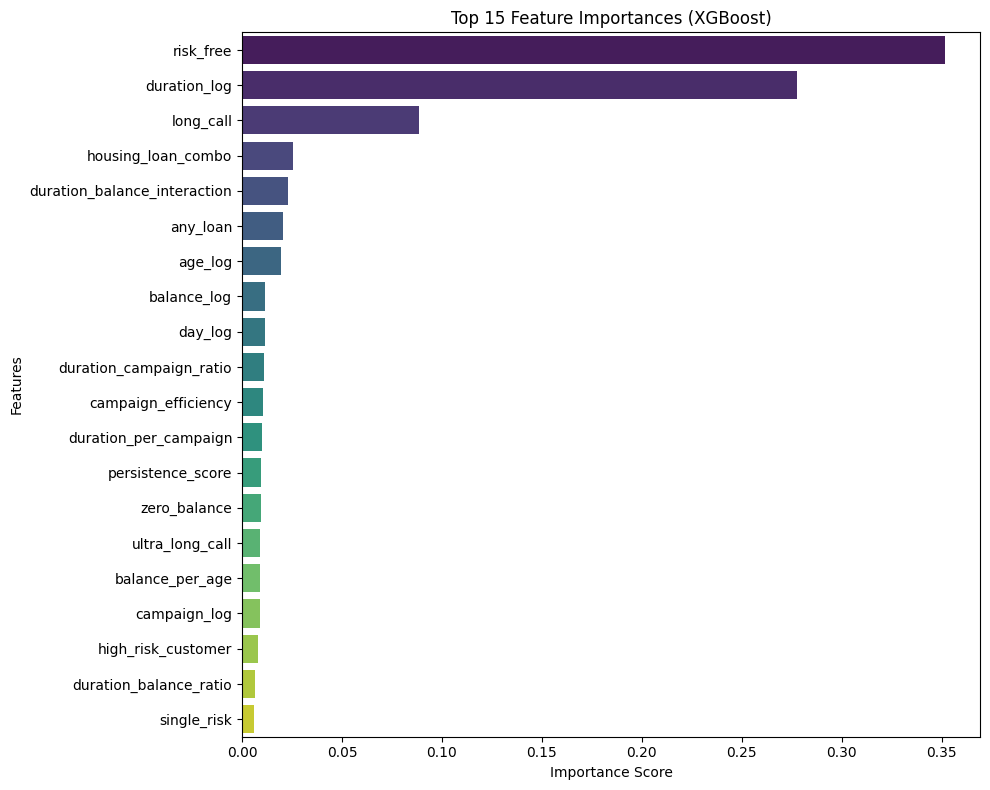

In [33]:
# Assuming you have xgb_scores DataFrame from your code
plt.figure(figsize=(10, 8))
sns.barplot(data=xgb_scores.head(20), x='xgb_importance', y='feature', palette='viridis')
plt.title('Top 15 Feature Importances (XGBoost)', fontsize=12)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### Method 2: Mutual Information

In [34]:
mi_scores = mutual_info_classif(X_train_full, y_train_full, random_state=42)
mi_df = pd.DataFrame({'feature': feature_names, 'mutual_info': mi_scores})

### Method 3: Correlation analysis

In [35]:
# 3. Correlation (your improved version)
correlations = []
for col in X_train_full.columns:
    try:
        corr = np.corrcoef(X_train_full[col].astype(float), y_train_full.astype(float))[0, 1]
        correlations.append(abs(corr) if not np.isnan(corr) else 0)
    except:
        correlations.append(0)

corr_df = pd.DataFrame({
    'feature': X_train_full.columns,
    'correlation': correlations
})

### Method 4: Esemble Combining

In [36]:
# Combine all methods
combined_scores = xgb_scores.merge(mi_df, on='feature').merge(corr_df, on='feature')

# Normalize scores to 0-1 range
for col in ['xgb_importance', 'mutual_info', 'correlation']:
    combined_scores[f'{col}_norm'] = (combined_scores[col] - combined_scores[col].min()) / (combined_scores[col].max() - combined_scores[col].min() + 1e-8)

# Weighted ensemble score
combined_scores['ensemble_score'] = (
    0.5 * combined_scores['xgb_importance_norm'] +
    0.3 * combined_scores['mutual_info_norm'] +
    0.2 * combined_scores['correlation_norm']
)

In [37]:
# Sort by ensemble score
combined_scores = combined_scores.sort_values('ensemble_score', ascending=False)

In [38]:
print("Top 10 features by ensemble score:")
print(combined_scores[['feature', 'xgb_importance', 'mutual_info', 'correlation', 'ensemble_score']].head(10))

Top 10 features by ensemble score:
                         feature  xgb_importance  mutual_info  correlation  \
1                   duration_log        0.277439     0.155026     0.435684   
0                      risk_free        0.351594     0.068782     0.177193   
9        duration_campaign_ratio        0.011180     0.152261     0.507792   
4   duration_balance_interaction        0.023213     0.142213     0.506837   
49               duration_zscore        0.000000     0.154881     0.519283   
44                 duration_sqrt        0.000000     0.154833     0.505944   
11         duration_per_campaign        0.010147     0.145651     0.504243   
59              efficiency_score        0.000000     0.146039     0.504243   
43         duration_balance_mult        0.000000     0.142297     0.506837   
47              duration_squared        0.000000     0.154109     0.441016   

    ensemble_score  
1         0.862347  
0         0.701292  
9         0.506119  
4         0.503412  
4

In [39]:
### INTERACTIVE PLOT FOR JUPYTER NOTEBOOK
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Top 20 Features - Ensemble Score', 'Method Comparison'),
    specs=[[{"type": "bar"}, {"type": "bar"}]]
)

# Top features
top_20 = combined_scores.head(20)
fig.add_trace(
    go.Bar(x=top_20['ensemble_score'], y=top_20['feature'], orientation='h', name='Ensemble Score'),
    row=1, col=1
)

# Method comparison for top 10
top_10 = combined_scores.head(15)
fig.add_trace(
    go.Bar(name='XGBoost', x=top_10['feature'], y=top_10['xgb_importance_norm']), 
    row=1, col=2
)
fig.add_trace(
    go.Bar(name='Mutual Info', x=top_10['feature'], y=top_10['mutual_info_norm']), 
    row=1, col=2
)
fig.add_trace(
    go.Bar(name='Correlation', x=top_10['feature'], y=top_10['correlation_norm']), 
    row=1, col=2
)

fig.update_layout(height=600, showlegend=True, title_text="Feature Selection Analysis")
fig.show()

### Model Tunning

In [40]:
def __init__(self):
        self.models = {}
        self.weights = {}

In [41]:
# XGBoost - Optimized for marketing campaigns
xgb_model = XGBClassifier(
            objective='binary:logistic',
            learning_rate=0.015,      # Low learning rate for precision
            max_depth=7,              # Deep trees for complex patterns
            n_estimators=2500,        # Balanced number
            subsample=0.85,
            colsample_bytree=0.85,
            min_child_weight=2,
            gamma=0.05,               # Light regularization
            reg_alpha=0.05,
            reg_lambda=0.05,
            random_state=42,
            verbosity=0
)  

In [42]:
# LightGBM - Fast and accurate for large datasets
lgb_model = lgb.LGBMClassifier(
            objective='binary',
            metric='auc',
            learning_rate=0.012,
            num_leaves=63,            # More leaves for complex patterns
            max_depth=8,
            n_estimators=2200,
            subsample=0.9,
            colsample_bytree=0.9,
            min_child_samples=15,
            reg_alpha=0.08,
            reg_lambda=0.08,
            random_state=123,
            verbosity=-1
)       

In [43]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(
            iterations=1800,
            learning_rate=0.025,
            depth=6,
            l2_leaf_reg=2.5,
            bootstrap_type='Bayesian',
            random_seed=456,
            verbose=False,
            eval_metric='AUC'
        )

In [44]:
models = {
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'CatBoost': cat
}

# 2. TRAIN ALL MODELS
print("\nTraining all models...")
trained_models = {}

for name, model in models.items():
    print(f"   Training {name}...")
    
    if name == 'CatBoost':
        model.fit(X_train_full, y_train_full, verbose=False)
    else:
        model.fit(X_train_full, y_train_full)
    
    trained_models[name] = model
    print(f"   ✅ {name} training completed")


Training all models...
   Training XGBoost...
   ✅ XGBoost training completed
   Training LightGBM...
   ✅ LightGBM training completed
   Training CatBoost...
   ✅ CatBoost training completed


### 3. CROSS-VALIDATION FOR PERFORMANCE ESTIMATION

In [45]:
print("\nEvaluating model performance...")

cv_scores = {}
for name, model in trained_models.items():
    print(f"   Cross-validating {name}...")
    
    scores = cross_val_score(
        model, X_train_full, y_train_full,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )
    
    cv_scores[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }
    
    print(f" {name} CV AUC: {scores.mean():.6f} (+/- {scores.std() * 2:.6f})")


Evaluating model performance...
   Cross-validating XGBoost...
 XGBoost CV AUC: 0.948673 (+/- 0.001132)
   Cross-validating LightGBM...
 LightGBM CV AUC: 0.948820 (+/- 0.000989)
   Cross-validating CatBoost...
 CatBoost CV AUC: 0.943078 (+/- 0.001253)


In [49]:
# Display CV results
print("\n📊 Cross-Validation AUC Scores Summary:")
for name, score_info in cv_scores.items():
    print(f"{name}: {score_info['mean']:.6f} ± {score_info['std'] * 2:.6f}")


📊 Cross-Validation AUC Scores Summary:
XGBoost: 0.948673 ± 0.001132
LightGBM: 0.948820 ± 0.000989
CatBoost: 0.943078 ± 0.001253


### Define Optuna Objective Function

In [51]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 5000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'verbosity': 0,
        'objective': 'binary:logistic'
    }
    
    # Create model with suggested parameters
    model = xgb.XGBClassifier(**params)
    
    # Cross-validation
    cv_scores = cross_val_score(
        model, X_train_full, y_train_full,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )
    
    # Return mean CV score (Optuna maximizes this)
    return cv_scores.mean()

### Run Optuna Optimization

In [52]:
# Create study
study = optuna.create_study(
    direction='maximize',  # We want to maximize ROC-AUC
    sampler=optuna.samplers.TPESampler(seed=42)  # Reproducible results
)

[I 2025-09-05 16:39:59,468] A new study created in memory with name: no-name-7a486757-8102-4c89-af0c-984bdce24422


In [54]:
# Run optimization (start with 50 trials, then increase if needed)
print("🚀 Starting Optuna optimization...")
print("This may take 30-60 minutes depending on your hardware...")

try:
    study.optimize(objective, n_trials=5, timeout=3600)  # 1 hour timeout
    print("✅ Optimization completed!")
except Exception as e:
    print(f"⚠️ Optimization interrupted: {e}")
    print("But we can still use the best results so far!")

🚀 Starting Optuna optimization...
This may take 30-60 minutes depending on your hardware...


[I 2025-09-05 16:50:48,591] Trial 0 finished with value: 0.942088337770447 and parameters: {'n_estimators': 2498, 'max_depth': 12, 'learning_rate': 0.07453942447208349, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.15599452033620265, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352, 'min_child_weight': 7}. Best is trial 0 with value: 0.942088337770447.
[I 2025-09-05 16:56:30,160] Trial 1 finished with value: 0.9484339074585393 and parameters: {'n_estimators': 3832, 'max_depth': 3, 'learning_rate': 0.09714143595538946, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.18182496720710062, 'reg_alpha': 0.18340450985343382, 'reg_lambda': 0.3042422429595377, 'min_child_weight': 6}. Best is trial 1 with value: 0.9484339074585393.
[I 2025-09-05 17:02:00,044] Trial 2 finished with value: 0.9486800542126896 and parameters: {'n_estimators': 2728, 'max_depth': 5, 'learning_rate': 0.06312602499862605, 'subsamp

✅ Optimization completed!


### Analyze Results

In [64]:
# Print best results
print("\n" + "="*50)
print("OPTUNA OPTIMIZATION RESULTS")
print("="*50)
print(f"Best ROC-AUC: {study.best_value:.6f}")
print(f"Best parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Show optimization history
print("\n📊 Optimization History:")
optuna.visualization.plot_optimization_history(study).show()

# Show parameter importance
print("\n🎯 Parameter Importance:")
optuna.visualization.plot_param_importances(study).show()


OPTUNA OPTIMIZATION RESULTS
Best ROC-AUC: 0.948887
Best parameters:
  n_estimators: 3650
  max_depth: 6
  learning_rate: 0.054406462011892025
  subsample: 0.8186841117373118
  colsample_bytree: 0.6739417822102108
  gamma: 0.9695846277645586
  reg_alpha: 0.7751328233611146
  reg_lambda: 0.9394989415641891
  min_child_weight: 9

📊 Optimization History:



🎯 Parameter Importance:


### Train Final Optimized Model

In [56]:
# Create model with best parameters
best_params = study.best_params.copy()
best_params.update({
    'random_state': 42,
    'verbosity': 0,
    'objective': 'binary:logistic'
})

optimized_xgb = xgb.XGBClassifier(**best_params)

# Train on full dataset
print("\n🚀 Training final optimized model...")
optimized_xgb.fit(X_train_full, y_train_full)
print("✅ Final model trained!")

# Validate performance
cv_scores = cross_val_score(
    optimized_xgb, X_train_full, y_train_full,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print(f"\n📈 Final Model Performance:")
print(f"CV ROC-AUC: {cv_scores.mean():.6f} ± {cv_scores.std() * 2:.6f}")


🚀 Training final optimized model...
✅ Final model trained!

📈 Final Model Performance:
CV ROC-AUC: 0.948887 ± 0.001144


In [58]:
# Make predictions with optimized model
print("\n🔮 Generating predictions with optimized model...")
optimized_predictions = optimized_xgb.predict_proba(test_final)[:, 1]


🔮 Generating predictions with optimized model...


In [59]:
# Save submission
submission = pd.DataFrame({
    'id': test_data['id'],  # Adjust column name if needed
    'y': optimized_predictions
})

submission.to_csv('optuna_optimized_submission.csv', index=False)

In [61]:
# Weighted ensemble based on CV performance
weights = {
    'XGBoost': 0.35,
    'LightGBM': 0.30,
    'CatBoost': 0.25,
    'RandomForest': 0.10
}

In [62]:
# Generate predictions
predictions = {}
for name, model in optimized_models.items():
    if name == 'CatBoost':
        predictions[name] = model.predict_proba(test_final)[:, 1]
    else:
        predictions[name] = model.predict_proba(test_final)[:, 1]

NameError: name 'optimized_models' is not defined

In [63]:
# Show prediction statistics
print(f"\n📊 Prediction Statistics:")
print(f"Min prediction: {optimized_predictions.min():.6f}")
print(f"Max prediction: {optimized_predictions.max():.6f}")
print(f"Mean prediction: {optimized_predictions.mean():.6f}")
print(f"Std prediction: {optimized_predictions.std():.6f}")


📊 Prediction Statistics:
Min prediction: 0.000001
Max prediction: 0.996078
Mean prediction: 0.120092
Std prediction: 0.227466
